In [1]:
import os
import glob
import uproot
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 150

import operator
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from IPython.display import clear_output
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from ipyfilechooser import FileChooser
from ordered_set import OrderedSet
from plotting_utils import get_results, Result#, plot_results

%matplotlib inline


In [2]:
def plot_results(results, name, log):

    vevds = OrderedSet([r.vevd for r in sorted(results, key=operator.attrgetter('vevd'), reverse=True)])
    mdpps = OrderedSet([r.mdpp for r in sorted(results, key=operator.attrgetter('mdpp'))])

    hmap = []
    
    print(vevds)

    for v in vevds:
        results_msorted = sorted(results, key=operator.attrgetter('mdpp'))
        hmap.append([r.quantity for r in results_msorted if r.vevd == v])
        
    hmap = np.array(hmap, dtype=float)

    fig, ax = plt.subplots()
    if log:
        sns.heatmap(hmap, annot=True, cmap="Oranges", xticklabels=mdpps, yticklabels=vevds, ax=ax,
                    fmt=".2", norm=LogNorm(), annot_kws={"size": 15 / np.sqrt(len(hmap))},
                    cbar_kws={'label': name});
    if not log:
        sns.heatmap(hmap, annot=True, cmap="Oranges", xticklabels=mdpps, yticklabels=vevds, ax=ax,
                    annot_kws={"size": 15 / np.sqrt(len(hmap))},
                    cbar_kws={'label': name});

    ax.set_xlabel(r"$M_{\Delta^{\pm\pm}}$ [GeV]");
    ax.set_ylabel(r"vevD [GeV]");

In [3]:
def select(sample_folder, variable, log):
    results = get_results(sample_folder, variable);
    plot_results(results, variable, log);

runs = glob.glob("../multirun/*")
choices = ["total_xs", "total_xs_error", "sum_of_weights", "sum_of_weights_err", "fid_sum_of_weights", "fid_sum_of_weights_err", "fid_xs", "fid_xs_err", "nsurvive_events", "ninit_events",  "presel_eff",   "cutflow"]

interact(select, sample_folder=runs, variable=choices, log=[True, False]);

interactive(children=(Dropdown(description='sample_folder', options=('../multirun/2023-03-13_typeII_single_pro…

In [4]:

def get_vevs_and_masses(sample_folder):
    folders = [p for p in glob.glob(f"{sample_folder}/*") if os.path.isdir(p)]
    vevds = []
    mdpps = []
    for fpath in folders:
        split_path = os.path.basename(fpath).split("_")
        vevds.append(float(split_path[-1]))
        mdpps.append(float(split_path[-2]))
    
    vevds.sort()
    mdpps.sort()
    vevds = OrderedSet(vevds)
    mdpps = OrderedSet(mdpps)
    
    return vevds, mdpps




In [11]:
out = widgets.Output()

class PlotSampleFolderWidget(widgets.HBox):

    def __init__(self):
        
        self.results = []
        self.avail_branches = []
        self.out_widg = widgets.Output()
        
        self.file_widg = FileChooser("../", show_only_dirs=True)
        self.vevd_widg = widgets.SelectMultiple( description='vevd', disabled=False)
        self.mass_widg = widgets.SelectMultiple( description='masses', disabled=False)
        self.branch_widg = widgets.SelectMultiple( description='observable', disabled=False)
        
        self.norm_widg = widgets.RadioButtons(options=['Unity', 'Xsec', 'None'], value='Unity', description='Normalisation', disabled=False)
        
        self.plot_widg = widgets.Button(description="Plot")
        self.plot_widg.on_click(self._plot)
        
        display(self.out_widg)

        self.selectors = [self.file_widg, self.vevd_widg, self.mass_widg, self.branch_widg, self.norm_widg, self.plot_widg]
        super().__init__(children=self.selectors)

        self._update_sample_path()    
        self.file_widg.register_callback(self._set_observes)
        self._set_observes()

    def _plot(self, b):
        self.plot_selection()

    def _update_sample_path(self):
        self.file_widg.refresh()
        self.results = []
        self.sample_folder = self.file_widg.selected_path
        self.vevds, self.masses = get_vevs_and_masses(self.sample_folder)

        self.vevd_widg.options = self.vevds
        self.mass_widg.options = self.masses

        root_files = glob.glob(f"{self.sample_folder}/*/output.root")
        
        for fpath in root_files:
            split_path = os.path.basename(os.path.dirname(fpath)).split("_")
            vevd = float(split_path[-1])
            mass = float(split_path[-2])

            if vevd in self.vevd_widg.get_interact_value() and mass in self.mass_widg.get_interact_value():
                self.results.append(Result(vevd, mass, file=fpath))
        
        if len(root_files) != 0:
            data = uproot.open(f"{root_files[0]}:tree")
            self.avail_branches = list(data.keys())
            self.branch_widg.options = self.avail_branches

    def _set_observes(self):
        self._update_sample_path()

        for widg in self.selectors:
            widg.observe(self._observed_function, names='value')


    def _observed_function(self, widg):
        self.sample_folder = self.file_widg.selected_path
        self._update_sample_path()

    def plot_selection(self):

        root_files = [r.file for r in self.results]

        if len(root_files) == 0: return

        selected_obs = self.branch_widg.get_interact_value()
        
        with self.out_widg:
            for i, obs in enumerate(selected_obs):
                fig, ax = plt.subplots();
                cm = plt.get_cmap('gist_rainbow');
                ncolors = len(root_files);
                ax.set_prop_cycle(color=[cm(1.*i/ncolors) for i in range(ncolors)]);
                
                for r in self.results:
                    self._make_hist(ax, r, obs);
                ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5));
                ax.set_xlabel(obs);
                display(fig)

            self.out_widg.clear_output(wait=True)
            plt.close('all');
        
    def _make_hist(self, ax, result, obs, bins=50, label=None):

        tree = uproot.open(f"{result.file}:tree");
        metadata = uproot.open(f"{result.file}:metadata");
        data = np.ravel(tree[obs].array());
        # weight = tree['weight'].array() # TODO - implement this in rivet
        if label is None:
            label = f"vevd={result.vevd}  mass={result.mdpp}";

        density = False
        weights = np.ones_like(data)
        if self.norm_widg.value == 'Unity':
            density = True
        elif self.norm_widg.value == 'Xsec':
            weights = weights * metadata['fid_xs']

        p = ax.hist(data, bins, label=label, histtype='step', density=density);
        return ax


Output()

PlotSampleFolderWidget(children=(FileChooser(path='/home/bewilson/MadHydra', filename='', title='', show_hidde…

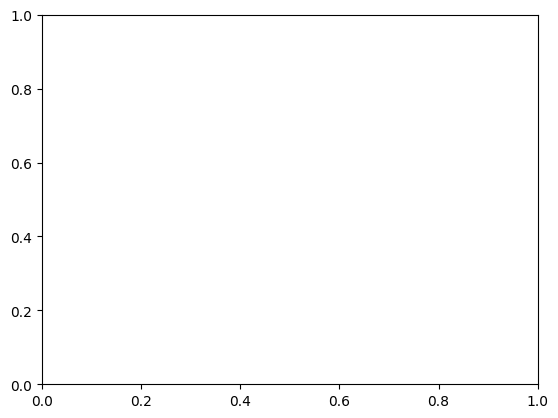

In [12]:
PlotSampleFolderWidget()